# Step 2: RHL Dose-Response Fitting Hill

This notebook performs dose-response analysis for RHL experiments, combining FACS and microfluidics data to perform a Hill curve fitting.

**What this code does:**
1. **Data Integration**: Loads pre-processed FACS and microscopy calibration data (output from `1b_calibrate_facs_microscope_rhl.ipynb`)
2. **Data Preparation**: Combines microscopy and FACS data for fitting
3. **Hill Curve Fitting**: Fits Hill function to the combined dataset to determine:
   - EC₅₀ (half-maximal effective concentration)
   - Hill coefficient (cooperativity parameter)  
   - Maximum response amplitude
4. **Model Validation**: Calculates AIC and BIC metrics for model assessment
5. **Output Generation**: Saves calibration parameters, fitted curve plots, and processed data

Response curve is fitted to background corrected fluorescent intensities in microscopy units. FACS intensities where converted to microscopy intensities in notebook 1. Here background is subtracted using mode of control distribution

In [5]:
import json
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path

# ——— Configuration ———
MICRO_CSV = Path.cwd().parent / 'datafiles' / 'rhl_calibration_microscopy.csv'
FACSCONVERTED_CSV = Path.cwd() / 'data' / '1_rhl_facs_transformed.csv'
BACKGROUND_JSON = Path.cwd() / 'data' / 'background_intensities.json'
OUTPUT_JSON = Path.cwd() / 'data' / '2_rhl_calibration_curve_hill.json'

RHL_ORDER = [
    'RHL_0','RHL_0_78125','RHL_1_5625','RHL_3_125',
    'RHL_6_25','RHL_12_5','RHL_25','RHL_50',
    'RHL_100','RHL_200','RHL_400','RHL_800'
]

# ——— Model definition ———
def hill_function(x, a, c, b):
    """Hill function: a * x**b / (c**b + x**b)"""
    return a * x**b / (c**b + x**b)

def summarize_replicate_data(df_all_replicates: pd.DataFrame, ) -> pd.DataFrame:
    """
    Calculate median, 25th and 75th percentiles from replicate data for each source and concentration.
    Keeps the excluded column in the output dataframe.
    
    Args:
        df_all_replicates: DataFrame with replicate-level data containing columns:
                          ['RHL', 'mcherry', 'conc', 'Source', 'excluded']    

    Returns:
        DataFrame with aggregated statistics

    """
    agg = (
        df_all_replicates
        .groupby(['RHL', 'Source', 'conc', 'excluded'], observed=True)
        .agg(
            mcherry_median=('mcherry', 'median'),
            mcherry_p25=('mcherry', lambda s: np.percentile(s, 25)),
            mcherry_p75=('mcherry', lambda s: np.percentile(s, 75)),
            n_replicates=('mcherry', 'count')
        )
        .reset_index()
    )
    
    # Calculate error bounds for plotting
    agg['mcherry_err_low'] = agg['mcherry_median'] - agg['mcherry_p25']
    agg['mcherry_err_high'] = agg['mcherry_p75'] - agg['mcherry_median']
    
    return agg

@dataclass
class Calibration:
    method: str
    params: dict
    AIC: float
    BIC: float

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        if self.method == "hill":
            a, c, b = self.params['a'], self.params['c'], self.params['b']
            return hill_function(x, a, c, b)
        else:
            raise ValueError(f"Unknown method {self.method}")

# Advanced customizable plotting function
def plot_dose_response_with_exclusion(df_all, 
                                     source_colors=None, 
                                     source_markers=None,
                                     source_sizes=None,
                                     figsize=(10, 6),
                                     linewidth=2,
                                     legend=True):
    """
    Plot dose-response data with different styling for included/excluded data.
    
    Parameters:
    -----------
    df_all : DataFrame
        Data with columns: Source, conc, excluded, mcherry_median, mcherry_err_low, mcherry_err_high
    source_colors : dict, optional
        Colors for each source. Default: {'Microscopy': 'tab:orange', 'FACS (estimated)': 'tab:blue'}
    source_markers : dict, optional  
        Markers for each source. Default: {'Microscopy': 'o', 'FACS (estimated)': 's'}
    source_sizes : dict, optional
        Sizes for each source. Default: {'Microscopy': 6, 'FACS (estimated)': 6}
    figsize : tuple
        Figure size
    linewidth : int
        Line width for error bars
    """
    
    # Default colors and markers
    if source_colors is None:
        source_colors = {
            'Microscopy': 'tab:orange',
            'FACS (estimated)': 'tab:blue'
        }
    
    if source_markers is None:
        source_markers = {
            'Microscopy': 'o',
            'FACS (estimated)': 's'
        }

    if source_sizes is None:
        source_sizes = {
            'Microscopy': 6,
            'FACS (estimated)': 6
        }    
    
    plt.figure(figsize=figsize)
    
    # Plot data by source and exclusion status
    for source in df_all['Source'].unique():
        source_data = df_all[df_all['Source'] == source]
        
        base_color = source_colors.get(source, 'tab:gray')
        marker = source_markers.get(source, 'o')
        size = source_sizes.get(source, 6)
        
        # Plot included data (filled symbols, full opacity)
        included_data = source_data[~source_data['excluded']]
        if len(included_data) > 0:
            plt.errorbar(
                included_data['conc'], 
                included_data['mcherry_median'],
                yerr=[included_data['mcherry_err_low'], included_data['mcherry_err_high']],
                fmt=marker,
                color=base_color,
                markerfacecolor=base_color,
                markeredgecolor=base_color,
                label=f'{source} (included)',
                alpha=0.8,
                capsize=3,
                markersize=size,
                linewidth=linewidth
            )
        
        # Plot excluded data (open symbols, reduced opacity)
        excluded_data = source_data[source_data['excluded']]
        if len(excluded_data) > 0:
            plt.errorbar(
                excluded_data['conc'], 
                excluded_data['mcherry_median'],
                yerr=[excluded_data['mcherry_err_low'], excluded_data['mcherry_err_high']],
                fmt=marker,
                color=base_color,
                markerfacecolor='none',
                markeredgecolor=base_color,
                label=f'{source} (excluded)',
                alpha=0.4,
                capsize=2,
                markersize=size,
                linestyle=None,
                linewidth=linewidth
            )

    plt.xscale('log')
    plt.xlabel('RHL Concentration [µg/mL]')
    plt.ylabel('mcherry Intensity [a.u.]')
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gca()

In [6]:
# ——— Data loading and processing ———
# Load raw microscopy data
micro = pd.read_csv(MICRO_CSV) # Load microscopy data
micro['RHL'] = (micro['RHL']
                 .str.replace('_µg','', regex=False)
                 .astype(pd.CategoricalDtype(RHL_ORDER, ordered=True)))

# Load converted FACS data (output of 1b_calibrate_facs_microscope_rhl.ipynb)
facs_converted = pd.read_csv(FACSCONVERTED_CSV) 
facs_converted['RHL'] = pd.Categorical(facs_converted['RHL'], categories=RHL_ORDER, ordered=True)

# Load background values
with open(BACKGROUND_JSON, 'r') as f:
    background_values = json.load(f)
bg_value = background_values['RHL']['bg_value']

# Compute microscopy medians over cells per chamber (to get per-replicate values)
micro_pos = (micro
             .groupby(['RHL','pos'], observed=True)['intensity_raw_mcherry']
             .median()
             .reset_index(name='mcherry'))

# Parse RHL concentrations (handle decimal values)
def parse_rhl_conc(label: str) -> float:
    """Parse RHL label to numeric concentration. Example: 'RHL_6_25' -> 6.25"""
    num = label.replace('RHL_', '')
    return float(num.replace('_', '.', 1))

micro_pos['conc'] = micro_pos['RHL'].apply(parse_rhl_conc).astype(float)
micro_pos['Source'] = 'Microscopy'

# Prepare FACS data (already at per-replicate level)
facs_converted['conc'] = facs_converted['RHL'].apply(parse_rhl_conc).astype(float)
facs_converted_prep = facs_converted.rename(columns={'predicted_micro_mcherry':'mcherry'})
facs_converted_prep['Source'] = 'FACS (estimated)'

# Combine all replicate-level data first
df_all_replicates = pd.concat([
    micro_pos[['RHL', 'mcherry', 'conc', 'Source']], 
    facs_converted_prep[['RHL', 'mcherry', 'conc', 'Source']]
], ignore_index=True)

df_all_replicates['RHL'] = pd.Categorical(df_all_replicates['RHL'], categories=RHL_ORDER, ordered=True)

# perform background correction using RHL=0 microscopy baseline
df_all_replicates['mcherry'] = df_all_replicates['mcherry'] - bg_value

# Add excluded column based on concentration criteria
# Use FACS data for all concentrations
df_all_replicates['excluded'] = False
df_all_replicates.loc[
    (df_all_replicates['Source'] == 'Microscopy'), 
    'excluded'
] = True

# Now calculate summary statistics (median, p25, p75) over replicates separately for each source
df_all = summarize_replicate_data(df_all_replicates)

# Create included subset for fitting (keeping original variable name for compatibility)
# Use the median values for fitting
df_included = df_all[~df_all['excluded']].copy()
df_included = df_included.rename(columns={'mcherry_median': 'mcherry'})

# ——— Hill curve fitting ———
# Prepare data for fitting
# Update 12.11.2025: background correction is now done above using RHL=0 microscopy baseline for shift
x_data = df_included['conc'].values
y_data = df_included['mcherry'].values  # already background corrected

# Fit Hill function
p0 = [float(np.max(y_data)), float(np.median(x_data)), 1.0]
popt, pcov = curve_fit(hill_function, x_data, y_data, p0=p0, maxfev=20000)
a_fit, c_fit, b_fit = popt

# Calculate metrics
y_pred = hill_function(x_data, *popt)
ssr = float(np.sum((y_data - y_pred) ** 2))
n, k = x_data.size, popt.size
sigma2 = ssr / max(n, 1)
aic = n * np.log(max(sigma2, 1e-12)) + 2 * k
bic = n * np.log(max(sigma2, 1e-12)) + k * np.log(max(n, 1))

params = {'a': a_fit, 'c': c_fit, 'b': b_fit}

# Save calibration parameters
cal = Calibration(method="hill", params=params, AIC=aic, BIC=bic)
with open(OUTPUT_JSON, 'w') as fj:
    json.dump(asdict(cal), fj, indent=2)

# Print summary
print(f"Hill parameters: a={params['a']:.2f}, c={params['c']:.2f}, b={params['b']:.2f}")
print(f"AIC = {aic:.1f}, BIC = {bic:.1f}")
print(f"Calibration saved to {OUTPUT_JSON}")
print(f"Total replicates: {len(df_all_replicates)}")
print(f"Median values for fitting: {len(df_included)}")

Hill parameters: a=10654.64, c=73.04, b=2.34
AIC = 154.7, BIC = 156.2
Calibration saved to /Users/simonvanvliet/Library/CloudStorage/Dropbox/Work/Code/Spatial Tolerance Model/1_dose_response_curves/data/2_rhl_calibration_curve_hill.json
Total replicates: 123
Median values for fitting: 12


/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_66416/2525569046.py:25: RuntimeWarning: invalid value encountered in scalar power
  return a * x**b / (c**b + x**b)


<Figure size 275.591x236.22 with 0 Axes>

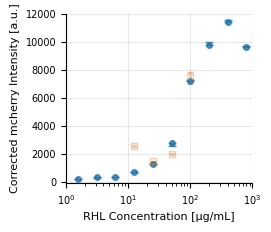

Filled symbols with darker colors: included data
Open symbols with lighter colors: excluded data
Error bars show 25th-75th percentile range across replicates
FACS data points are smaller circles, Microscopy data points are larger squares
For low RHL values (<50 µg/mL), signal is below limit of detection of FACS


In [7]:
# ——— Figure styling ———
final_width_cm = 7
final_height_cm = 6
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

OUTPUT_PDF = Path.cwd() / 'figures' / 'rhl_facs_microfluidic_response_curve.pdf'

# Enhanced plot with exclusion-based styling using the new data structure
plt.figure(figsize=(final_width_in, final_height_in))

# Define colors and markers for each source
source_colors = {
    'Microscopy': 'tab:orange',
    'FACS (estimated)': 'tab:blue'
}

source_markers = {
    'Microscopy': 's',
    'FACS (estimated)': 'o'
}

source_size = {
    'Microscopy': 5,
    'FACS (estimated)': 4
}

ax = plot_dose_response_with_exclusion(df_all, 
                                     source_colors=source_colors, 
                                     source_markers=source_markers,
                                     source_sizes=source_size,
                                     figsize=(final_width_in, final_height_in),
                                     linewidth=2,
                                     legend=False)

plt.xscale('log')
plt.xlabel('RHL Concentration [µg/mL]', fontsize=font_size)
plt.ylabel('Corrected mcherry Intensity [a.u.]', fontsize=font_size)
ax.tick_params(labelsize=font_size-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, alpha=0.3)

plt.xlim(1, 1000)
plt.ylim(-50,12000)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, dpi=300, transparent=True)
plt.show()

print("Filled symbols with darker colors: included data")
print("Open symbols with lighter colors: excluded data")
print("Error bars show 25th-75th percentile range across replicates")
print("FACS data points are smaller circles, Microscopy data points are larger squares")
print("For low RHL values (<50 µg/mL), signal is below limit of detection of FACS")

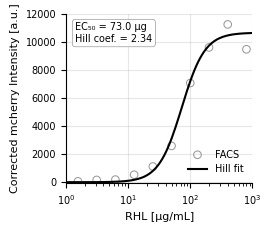

In [8]:
# ——— Figure styling ———
final_width_cm = 7
final_height_cm = 6
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

OUTPUT_PDF = Path.cwd() / 'figures' / 'rhl_fitted_dose_response_curve.pdf'

# ——— Plot Hill Function ———
min_val = 1E-3 if x_data.min() <= 0 else x_data.min()
x_fit = np.logspace(np.log10(min_val), 3, 200)
y_fit = hill_function(x_fit, a_fit, c_fit, b_fit)

fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

teal_color = 'grey'
source_label_map = {
    'FACS (estimated)': 'FACS',
    'Microscopy': 'Microscopy'
}

# Plot data points with different styles
for src, sub in df_included.groupby('Source'):
    clean_label = source_label_map.get(src, src)
    if src == 'Microscopy':
        ax.scatter(sub['conc'], sub['mcherry'] - df_included['mcherry'].min(), 
                  s=30, label=clean_label, color=teal_color, 
                  marker='o', edgecolors='none', alpha=0.8)
    elif src == 'FACS (estimated)':
        ax.scatter(sub['conc'], sub['mcherry'] - df_included['mcherry'].min(), 
                  s=30, label=clean_label, facecolors='none', 
                  edgecolors=teal_color, marker='o', linewidths=0.75, alpha=0.8)

# Plot Hill fit
ax.plot(x_fit, y_fit, c='black', linewidth=1.5, label='Hill fit')

ax.set_xscale('log')
ax.set_xlabel('RHL [µg/mL]', fontsize=font_size)
ax.set_ylabel('Corrected mcherry Intensity [a.u.]', fontsize=font_size)
ax.tick_params(labelsize=font_size-1)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=font_size-1, frameon=False, loc='lower right')

# Add parameter text box
textstr = f'EC₅₀ = {c_fit:.1f} µg\nHill coef. = {b_fit:.2f}'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
        fontsize=font_size-1, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                 edgecolor='gray', linewidth=0.5))

plt.xlim(1, 1000)
plt.ylim(-50,12000)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_PDF, dpi=300, transparent=True)
plt.show()